### Modelling memory distortions with a variational autoencoder: DRM experiment using news articles dataset

The Deese-Roediger-McDermott task is a classic way to measure memory distortion. This notebook tries to recreate the human results in VAE and AE models.

Steps:
* Process dataset of CNN / Daily Mail news articles (https://www.tensorflow.org/datasets/catalog/cnn_dailymail) into lists of words (ignoring order)
* Vectorize these (into vectors of word counts, removing most common and least common to reduce dimension)
* Train VAE and normal AE to reconstruct word vectors
* Explore whether we see 'intrusion of semantically related items' when network recalls a list
* Use the word lists at https://www3.nd.edu/~memory/OLD/Materials/DRM.pdf to test this - are the lure words falsely recalled?
* Explore what generating word lists from latent space tells us about the 'semantic memory' of the network

In [ ]:
!pip install tensorflow==2.3.1
!pip install tensorflow_datasets

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(1234)

#### Load data and preprocess

Each article has a time ID and place ID to represent the context of a memory.

This is provided by adding 'PLACE_ID_X TIME_ID_Y' to the start of the article.

In [2]:
ds = tfds.load('cnn_dailymail', split='train')

articles = []
for example in ds: 
    articles.append(example["article"].numpy().decode("utf-8"))
    
print(len(articles))

287113


#### Load DRM word lists

Load subset of lists from https://www3.nd.edu/~memory/OLD/Materials/DRM.pdf

In [3]:
DRM_lists = []
lures = []

DRM_lists.append(['STEAL', 'ROBBER', 'JAIL', 'VILLAIN', 'BANDIT', 'CRIMINAL', 'ROB','COP', 'MONEY', 'BAD', 'BURGLAR', 'CROOK', 'CRIME', 'GUN', 'BANK'])
lures.append('THIEF')

DRM_lists.append(['CLINIC', 'HEALTH', 'MEDICINE', 'SICK', 'STETHOSCOPE', 'CURE', 'NURSE', 'SURGEON', 'PATIENT', 'HOSPITAL', 'DENTIST', 'PHYSICIAN', 'ILL'])
lures.append('DOCTOR')

DRM_lists.append(['CHILLY', 'HOT', 'WET', 'WINTER', 'FREEZE', 'FRIGID', 'HEAT', 'SNOW', 'ARCTIC', 'AIR', 'WEATHER', 'SHIVER', 'ICE', 'FROST', 'WARM'])
lures.append('COLD')

DRM_lists.append(['truck', 'bus', 'train', 'automobile', 'vehicle', 'drive', 'jeep', 'Ford', 'race', 'keys', 'garage', 'highway', 'sedan', 'van', 'taxi'])
lures.append('car')

DRM_lists.append(['bed', 'rest', 'awake', 'tired', 'dream', 'wake', 'snooze', 'blanket', 'doze', 'slumber', 'snore', 'nap', 'peace', 'yawn', 'drowsy'])
lures.append('sleep')

In [4]:
all_sents = []

for a in articles:
    sents = a.split('. ')
    all_sents.extend(sents)
    
print(len(all_sents))

10651500


In [5]:
def check_lures(article, lure_list):
    for l in lure_list:
        if ' {} '.format(l.lower()) in article.lower():
            return True
    return False

filtered = [i for i in all_sents if check_lures(i, lures)==True]

flat_DRM = [item for sublist in DRM_lists for item in sublist]
filtered = [i for i in filtered if check_lures(i, flat_DRM)==True]

In [6]:
len(filtered)

17161

In [7]:
even_filtered = []

for l in lures:
    print(l)
    print(len([f for f in filtered if l.lower() in f.lower()]))
    even_filtered.extend([f for f in filtered if l.lower() in f.lower()][0:500])
    
for l in lures:
    print(l)
    print(len([f for f in even_filtered if l.lower() in f.lower()]))
    
filtered = even_filtered

THIEF
308
DOCTOR
2531
COLD
3525
car
10108
sleep
1548
THIEF
312
DOCTOR
539
COLD
533
car
736
sleep
524


In [8]:
texts = [' '.join(l) for l in DRM_lists] + filtered

In [9]:
len(texts)

2313

The cell below vectorizes the articles - it turns 'word1 word2 word3' into a vector with 1 at index for word1, 1 at index for word2, and 1 at index for word3. vectorizer.vocabulary_ stores the mapping of words to indices.

To make the vocabulary manageable, I filter out words in greater than or fewer than a certain number of documents:

In [10]:
vectorizer = CountVectorizer(max_df=0.5, min_df=0.005)
X=vectorizer.fit_transform(texts)
print(len(vectorizer.get_feature_names()))

691


In [11]:
texts = ["ID_{} ".format(ind) + ' '.join(list(vectorizer.inverse_transform(item)[0])[0:40]) if ind<20 
         else ' '.join(list(vectorizer.inverse_transform(item)[0])[0:40]) for ind, item in enumerate(X)]

In [12]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)
print(len(vectorizer.get_feature_names()))

711


In [13]:
x_train = X.toarray()

#### Function to build VAE:

In [26]:
class Sampling(layers.Layer):
    # Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the encoder
def build_encoder_decoder(latent_dim=100, input_dim = len(vectorizer.get_feature_names())):
    encoder_inputs = keras.Input(shape=(input_dim,))
    dropped_out = layers.Dropout(0.6, name="dropout_layer")(encoder_inputs)
    z_mean = layers.Dense(latent_dim, name="z_mean")(dropped_out)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder_inputs)
    # This uses the special sampling layer defined above:
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    ## Build the decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    decoder_outputs = layers.Dense(input_dim)(latent_inputs)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    
    return encoder, decoder


In [27]:
## Define the VAE as a `Model` with a custom `train_step` 
# In inherits from the keras Model class, giving it all the properties of a usual keras model

class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def train_step(self, data):
        input_dim = len(vectorizer.get_feature_names())
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            #reconstruction_loss *= input_dim
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + self.beta*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [71]:
def recall_list(test_item, encoder, decoder, with_scores=False):
    word_lookup = {v:k for k,v in vectorizer.vocabulary_.items()}
    encoded = encoder.predict(vectorizer.transform([test_item]))
    decoded = decoder.predict(encoded)
    
    if with_scores == True:
        return([(word_lookup[index], decoded[0][index]) for index in np.argsort(-decoded)[0]]) 
    else:
        return([word_lookup[index] for index in np.argsort(-decoded)[0]])


In [30]:
def train_vae(eps=1000, ld=200, beta=0.0001):
    encoder, decoder = build_encoder_decoder(latent_dim=ld)
    vae = VAE(encoder, decoder, beta)
    vae.compile(optimizer='adam')
    vae.fit(x_train, epochs=eps, batch_size=128, verbose=False, shuffle=True)
    return vae


In [31]:
def get_drm_results(vae):
    lure_positions = []
    recall_accuracies = []

    for ind, DRM_list in enumerate(DRM_lists):
        in_vocab = [i.lower() for i in DRM_list if i.lower() in vectorizer.vocabulary_.keys()]
        print("Words in DRM list for lure '{}':".format(lures[ind].lower()))
        print(in_vocab)
        test_item = "id_{}".format(ind) #' '.join([i.lower() for i in DRM_list])
        encoded = vae.encoder.predict(vectorizer.transform([test_item]))
        decoded = vae.decoder.predict(encoded)
        print("Recalled list:")
        top_words = [word_lookup[index] for index in np.argsort(-decoded)[0]]
        print(top_words[0:50])
        print(len(top_words))
        lure_positions.append(top_words.index(lures[ind].lower()))
        
        pred = top_words[0:len(in_vocab)]
        true = in_vocab
        correct = [p for p in pred if p in in_vocab]
        acc = len(correct) / len(true)
        recall_accuracies.append(acc)
        
        print("...........")
        
    return lure_positions, recall_accuracies
   

### Plot charts

In [32]:
vae = train_vae(eps=500, ld=100, beta=0.0005)

In [77]:
vae_ld60 = train_vae(eps=500, ld=60, beta=0.0005)
vae_ld70 = train_vae(eps=500, ld=70, beta=0.0005)
vae_ld80 = train_vae(eps=500, ld=80, beta=0.0005)
vae_ld90 = train_vae(eps=500, ld=90, beta=0.0005)
vae_ld100 = train_vae(eps=500, ld=100, beta=0.0005)
vae_ld110 = train_vae(eps=500, ld=110, beta=0.0005)
vae_ld120 = train_vae(eps=500, ld=120, beta=0.0005)
vae_ld130 = train_vae(eps=500, ld=130, beta=0.0005)

In [54]:
for ind, DRM_list in enumerate(DRM_lists):
    in_vocab = [i.lower() for i in DRM_list if i.lower() in vectorizer.vocabulary_.keys()]
    print("Words in DRM list for lure '{}':".format(lures[ind].lower()))
    print(in_vocab)
    test_item = 'id_{}'.format(ind) #' '.join([i.lower() for i in DRM_list])
    encoded = vae_ld140.encoder.predict(vectorizer.transform([test_item]))
    decoded = vae_ld140.decoder.predict(encoded)
    print("Recalled list:")
    top_words = [word_lookup[index] for index in np.argsort(-decoded)[0][0:20]]
    print(top_words)
    print("...........")


Words in DRM list for lure 'thief':
['steal', 'jail', 'criminal', 'money', 'bad', 'burglar', 'crime', 'gun', 'bank']
Recalled list:
['thief', 'steal', 'gun', 'bad', 'bank', 'id_0', 'jail', 'make', 'last', 'money', 'made', 'crime', 'car', 'mental', 'said', 'claims', 'or', 'be', 'general', 'able']
...........
Words in DRM list for lure 'doctor':
['clinic', 'health', 'medicine', 'sick', 'cure', 'nurse', 'patient', 'hospital', 'physician', 'ill']
Recalled list:
['hospital', 'doctor', 'said', 'health', 'cure', 'patient', 'or', 'car', 'it', 'have', 'of', 'medicine', 'at', 'make', 'cold', 'them', 'last', 'physician', 'too', 'sleep']
...........
Words in DRM list for lure 'cold':
['hot', 'wet', 'winter', 'freeze', 'heat', 'snow', 'arctic', 'air', 'weather', 'ice', 'warm']
Recalled list:
['cold', 'hot', 'heat', 'winter', 'able', 'home', 'wet', 'don', 'son', 'weather', 'who', 'local', 'just', 'her', 'take', 'like', 'any', 'or', 'snow', 'says']
...........
Words in DRM list for lure 'car':
['truc

In [73]:
lures

['THIEF', 'DOCTOR', 'COLD', 'car', 'sleep']

In [86]:
all_probs = []

for i in range(8):
    print("LD = {}:".format(60 + i*10))
    probs = []
    for j in range(5):
        print(j)
        vae = train_vae(eps=100, ld=60 + i*10, beta=0.0005)
        for k in range(5):
            try:
                recalled = recall_list('id_{}'.format(k), vae.encoder, vae.decoder, with_scores=True)
                terms = [item[0] for item in recalled]
                scores = [item[1] for item in recalled]
                term_ind = terms.index(lures[k].lower())
                probs.append(scores[term_ind])
            except Exception as e:
                print(e)
    print(probs) 
    all_probs.append(np.mean(probs))

LD = 60:
0
1
2
3
4
[0.095031634, 0.16796309, 0.11442423, 0.10697013, 0.18939541, 0.06952366, 0.18172324, 0.1745294, 0.17065775, 0.21137556, 0.11658339, 0.092280656, 0.30955303, 0.17560045, 0.1228325, 0.16200173, 0.11447257, 0.0027873293, 0.07365658, 0.22930747, 0.13614091, 0.20980169, 0.1641684, 0.18580545, 0.18915264]
LD = 70:
0
1
2
3
4
[0.12256949, 0.098482, 0.14121273, 0.14113265, 0.101209514, 0.085446805, 0.1460055, 0.20778489, 0.20442472, 0.19932047, 0.093222775, 0.18606815, 0.18619034, 0.023137037, 0.20270145, 0.10589882, 0.1373542, 0.11672233, 0.09652052, 0.11341172, 0.083411455, 0.16614693, 0.098745346, 0.18367726, 0.24243227]
LD = 80:
0
1
2
3
4
[0.11009711, 0.08950798, 0.17109397, 0.13299048, -0.0038102344, 0.058742642, 0.14277673, 0.11350484, 0.047901276, 0.11524624, 0.07115774, 0.030321375, 0.14876975, 0.17099652, 0.09033362, 0.12857422, 0.200754, 0.043524995, 0.19214873, 0.08305007, 0.056986965, 0.15122446, 0.092951044, -0.026875254, 0.06367502]
LD = 90:
0
1
2
3
4
[0.074304

In [87]:
all_probs

[0.15062957,
 0.13932918,
 0.09902576,
 0.11773107,
 0.096819125,
 0.09264809,
 0.08410967,
 0.056828834]

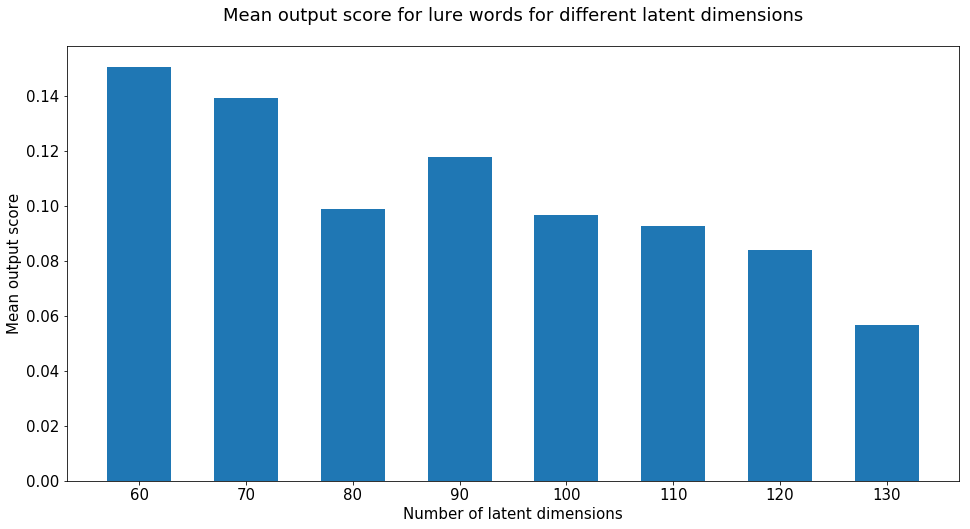

<Figure size 1152x576 with 0 Axes>

In [104]:
plt.bar([60 + i*10 for i in range(8)], all_probs, width = 6)

plt.xlabel('Number of latent dimensions') 
plt.ylabel('Mean output score') 
  
# displaying the title
plt.title("Mean output score for lure words for different latent dimensions")

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (16,8),
          'axes.labelsize': size,
          'axes.titlesize': size*1.2,
          'xtick.labelsize': size,
          'ytick.labelsize': size}
plt.rcParams.update(params)
  
plt.show()
plt.savefig('mean_output_scores.png')

In [66]:
lures

['THIEF', 'DOCTOR', 'COLD', 'car', 'sleep']

Text(0.5, 1.0, "Recalled words for input 'id_2' (lure word 'cold')")

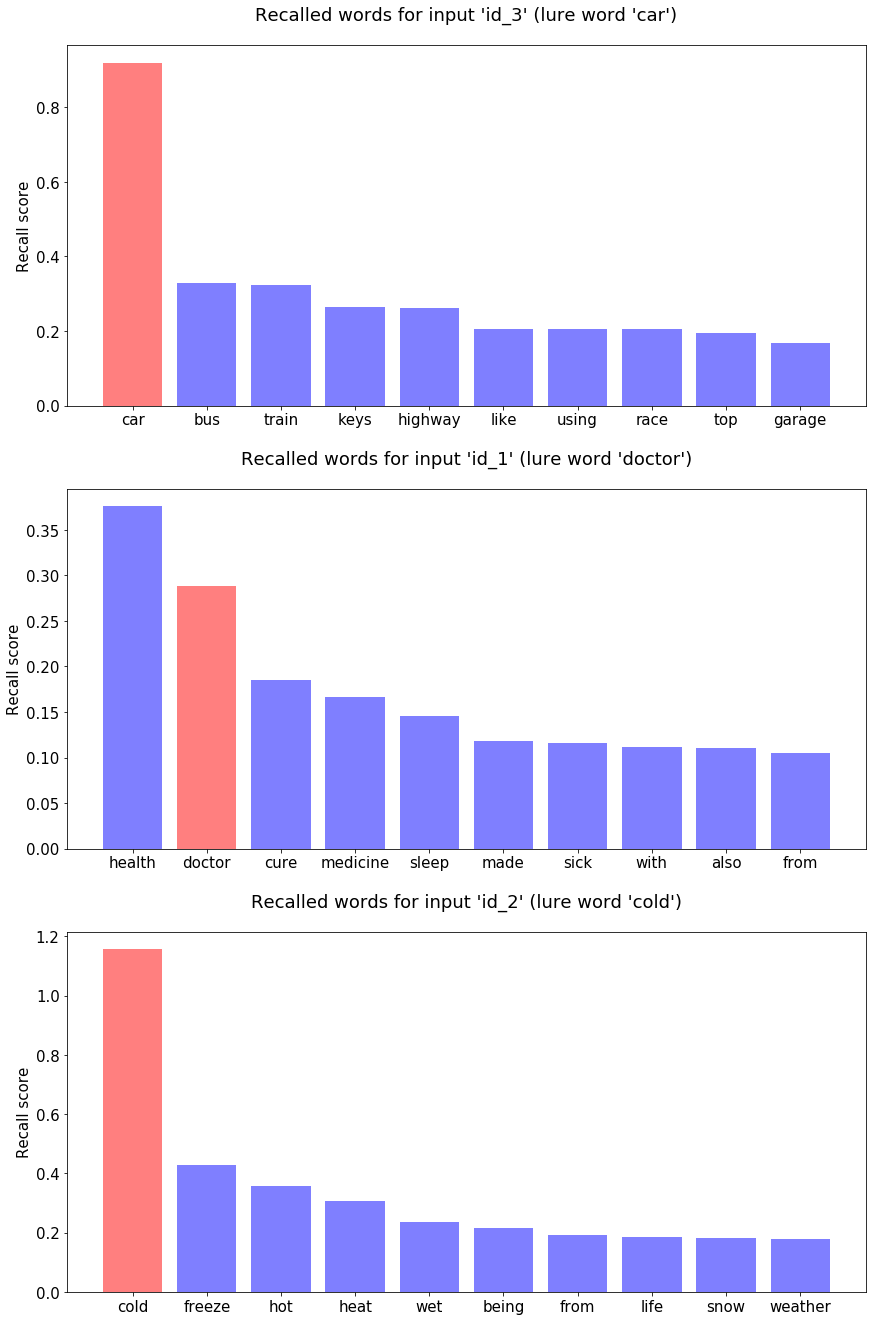

In [61]:
vae = vae_ld80

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size*1.2,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
         'axes.titlepad': 25}
plt.rcParams.update(params)

fig, axs = plt.subplots(3,1, figsize=(12,18))
fig.tight_layout(h_pad=5.5)

recalled = recall_list('id_1', vae.encoder, vae.decoder, with_scores=True)[0:10]
terms = [i[0] for i in recalled]
scores = [i[1] for i in recalled]
clrs = ['red' if x == 'doctor' else 'blue' for x in terms]

axs[1].bar(terms, scores, color=clrs, alpha=0.5)
axs[1].set_ylabel('Recall score')
axs[1].set_title("Recalled words for input 'id_1' (lure word 'doctor')")

recalled = recall_list('id_3', vae.encoder, vae.decoder, with_scores=True)[0:10]
terms = [i[0] for i in recalled]
scores = [i[1] for i in recalled]
clrs = ['red' if x == 'car' else 'blue' for x in terms]

axs[0].bar(terms, scores, color=clrs, alpha=0.5)
axs[0].set_ylabel('Recall score')
axs[0].set_title("Recalled words for input 'id_3' (lure word 'car')")

recalled = recall_list('id_2', vae.encoder, vae.decoder, with_scores=True)[0:10]
terms = [i[0] for i in recalled]
scores = [i[1] for i in recalled]
clrs = ['red' if x == 'cold' else 'blue' for x in terms]

axs[2].bar(terms, scores, color=clrs, alpha=0.5)
axs[2].set_ylabel('Recall score')
axs[2].set_title("Recalled words for input 'id_2' (lure word 'cold')")

In [38]:
#fig.savefig('vae_eps500_ld100_beta0.0005.png', bbox_inches='tight')

### Basic autoencoder for comparison

Compare VAE with standard AE.

In [39]:
def train_ae(n=40, opt='rmsprop', eps=1000):
    num_words=len(vectorizer.get_feature_names())

    input_layer = keras.Input(shape=(num_words,))
    encoded = layers.Dropout(0.5)(input_layer)
    encoded = layers.Dense(n, activation='relu')(encoded)
    decoded = layers.Dense(num_words, activation='sigmoid')(encoded)

    autoencoder = keras.Model(input_layer, decoded)

    encoder = keras.Model(input_layer, encoded)

    encoded_input = keras.Input(shape=(n,))
    decoder_layer = autoencoder.layers[-1]
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

    autoencoder.fit(x_train, x_train,
                   epochs=eps,
                   batch_size=128,
                   shuffle=True,
                   verbose=False)
    
    return autoencoder, encoder, decoder

#autoencoder, encoder, decoder = train_ae(eps=2000, n=70, opt='rmsprop')

In [40]:
word_lookup = {v:k for k,v in vectorizer.vocabulary_.items()}

def recall_list(test_item, encoder, decoder, with_scores=False):
    encoded = encoder.predict(vectorizer.transform([test_item]))
    decoded = decoder.predict(encoded)
    
    if with_scores == True:
        return([(word_lookup[index], decoded[0][index]) for index in np.argsort(-decoded)[0]][0:30]) 
    else:
        return([word_lookup[index] for index in np.argsort(-decoded)[0]][0:30])

In [41]:
def evaluate_model(encoder, decoder):
    ints = []
    for i in range(14):
        true = texts[i].split()
        pred = recall_list("id_{}".format(i), encoder, decoder)[0:len(true)]
        intersection = [val for val in true if val in pred]
        ints.append(len(intersection))
    print(sum(ints))
    return(sum(ints))

In [ ]:
eps_to_try = [10,20,50,100,200,250,300,350,400, 500,1000, 2000]
opt_to_try = ['sgd', 'rmsprop', 'adam']
n_to_try = [5,10,20,30,40,50,60,80, 100, 150, 200,250,300,400]

params = []
scores = []

for ep in eps_to_try:
    for opt in opt_to_try:
        for n in n_to_try:
            autoencoder, encoder, decoder = train_ae(eps=ep, n=n, opt=opt)
            score = evaluate_model(encoder, decoder)
            params.append([ep,n,opt])
            scores.append(score)
            print([ep,n,opt])
            print(score)
            
params[np.argmax(scores)]

In [46]:
# eps = 6000
autoencoder, encoder, decoder = train_ae(eps=10000, n=30, opt='adam')

In [47]:
for ind, DRM_list in enumerate(DRM_lists):
    in_vocab = [i.lower() for i in DRM_list if i.lower() in vectorizer.vocabulary_.keys()]
    print("Words in DRM list for lure '{}':".format(lures[ind].lower()))
    print(in_vocab)
    test_item = 'id_{}'.format(ind) #' '.join([i.lower() for i in DRM_list])
    encoded = encoder.predict(vectorizer.transform([test_item]))
    decoded = decoder.predict(encoded)
    print("Recalled list:")
    top_words = [word_lookup[index] for index in np.argsort(-decoded)[0][0:20]]
    print(top_words)
    print("...........")
    

Words in DRM list for lure 'thief':
['steal', 'jail', 'criminal', 'money', 'bad', 'burglar', 'crime', 'gun', 'bank']
Recalled list:
['id_0', 'burglar', 'bank', 'jail', 'thief', 'health', 'gun', 'cold', 'john', 'bad', 'cure', 'steal', 'is', 'money', 'sleep', 'from', 'has', 'found', 'she', 'needed']
...........
Words in DRM list for lure 'doctor':
['clinic', 'health', 'medicine', 'sick', 'cure', 'nurse', 'patient', 'hospital', 'physician', 'ill']
Recalled list:
['id_1', 'cure', 'sick', 'health', 'ill', 'doctor', 'its', 'medicine', 'at', 'clinic', 'nurse', 'patient', 'including', 'physician', 'hospital', 'by', 'first', 'police', 'money', 'found']
...........
Words in DRM list for lure 'cold':
['hot', 'wet', 'winter', 'freeze', 'heat', 'snow', 'arctic', 'air', 'weather', 'ice', 'warm']
Recalled list:
['id_2', 'sleep', 'air', 'hot', 'cold', 'escape', 'wet', 'from', 'winter', 'car', 'in', 'warm', 'freeze', 'arctic', 'is', 'heat', 'weather', 'through', 'night', 'its']
...........
Words in DRM

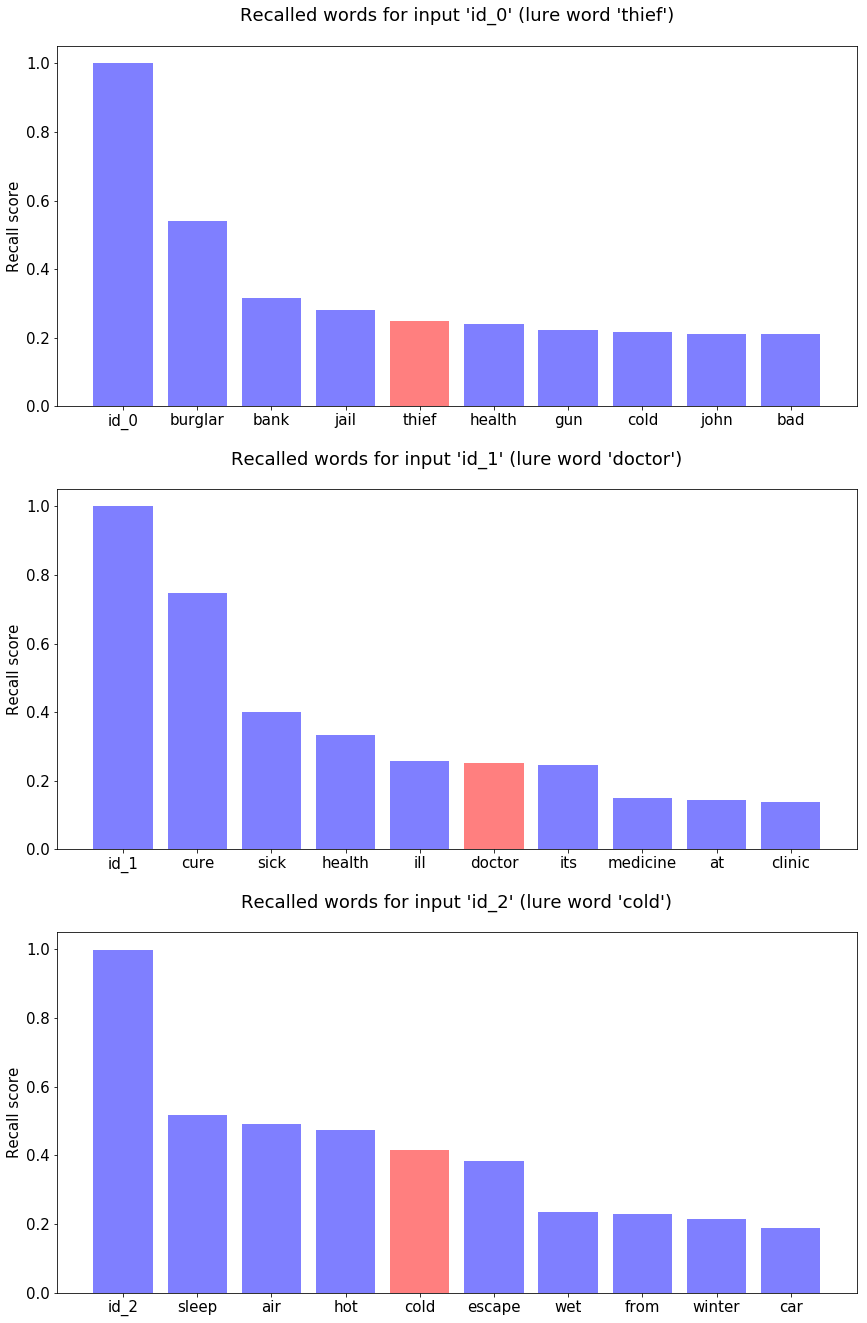

In [50]:
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size*1.2,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
         'axes.titlepad': 25}
plt.rcParams.update(params)

fig, axs = plt.subplots(3,1, figsize=(12,18))
fig.tight_layout(h_pad=5.5)

recalled = recall_list('id_1', encoder, decoder, with_scores=True)[0:10]
terms = [i[0] for i in recalled]
scores = [i[1] for i in recalled]
clrs = ['red' if x == 'doctor' else 'blue' for x in terms]

axs[1].bar(terms, scores, color=clrs, alpha=0.5)
axs[1].set_ylabel('Recall score')
axs[1].set_title("Recalled words for input 'id_1' (lure word 'doctor')")

recalled = recall_list('id_0', encoder, decoder, with_scores=True)[0:10]
terms = [i[0] for i in recalled]
scores = [i[1] for i in recalled]
clrs = ['red' if x == 'thief' else 'blue' for x in terms]

axs[0].bar(terms, scores, color=clrs, alpha=0.5)
axs[0].set_ylabel('Recall score')
axs[0].set_title("Recalled words for input 'id_0' (lure word 'thief')")

recalled = recall_list('id_2', encoder, decoder, with_scores=True)[0:10]
terms = [i[0] for i in recalled]
scores = [i[1] for i in recalled]
clrs = ['red' if x == 'cold' else 'blue' for x in terms]

axs[2].bar(terms, scores, color=clrs, alpha=0.5)
axs[2].set_ylabel('Recall score')
axs[2].set_title("Recalled words for input 'id_2' (lure word 'cold')")

fig.savefig('ae_10000eps_30dim_adam.png', bbox_inches='tight')